In [62]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns

In [64]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [65]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [66]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [67]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [68]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [69]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [71]:
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [72]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [87]:
# Calculate the date 1 year ago from the last data point in the database
year_session = dt.date(2017,8,23) - dt.timedelta(days=365)
year_session

datetime.date(2016, 8, 23)

In [74]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
sel = [
    Measurement.date,
    Measurement.prcp
]

Precipitation_data = session.query(*sel). \
filter(Measurement.date > year_session). \
order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

Precipitation_data_df = pd.DataFrame(data=Precipitation_data,columns=["Date","Precipitation"])
Precipitation_data_df.set_index('Date').head()

,Precipitation
Date,
2016-08-29,0.000000
2016-08-29,0.170000
2016-08-29,0.040000
2016-08-29,0.160644
2016-08-29,0.000000


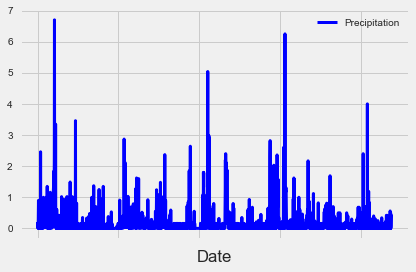

In [75]:
# Use Pandas Plotting with Matplotlib to plot the data
Precipitation_data_df.plot('Date', 'Precipitation', color = 'blue',linewidth=3)
plt.xlabel("Date")
plt.ylabel("")
plt.title("")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('images/prep_analysis')
plt.show()

In [76]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precipitation_data_df.describe()

,Precipitation
count,2191.000000
mean,0.171279
std,0.431422
min,0.000000
25%,0.000000
50%,0.030000
75%,0.160644
max,6.700000


In [77]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9)]

In [78]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sta =session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

In [79]:
#  Which station has the highest number of observations?
# Choose the station with the highest number of temperature observations.
station_high_T = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station_high_T

('USC00519281', 2772)

In [80]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
              group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active

(54.0, 85.0, 71.66378066378067)

In [81]:
#Design a query to retrieve the last twelve months of temperature observation data (tobs)

Temp_last12 = session.query(Measurement.date, Measurement.tobs).group_by(Measurement.date).\
    filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-28').all()


In [82]:
#Use the same query but also filter by station with highest number of temperature observation counts
Temp_last12_station = session.query(Measurement.station, Measurement.date, Measurement.tobs).group_by(Measurement.date).\
    filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-28').\
    filter(Measurement.station=="USC00519281").all()

In [83]:
#Put queried data into dataframe so it can be plotted as histogram
plot_qry_to_pd = pd.DataFrame(data=Temp_last12_station, columns=["station", "date", "tobs"])
plot_qry_to_pd = plot_qry_to_pd.set_index('date', drop=True)
plot_qry_to_pd = plot_qry_to_pd.drop(columns="station", axis=1)
plot_qry_to_pd.head()

,tobs
date,
2016-08-28,73.0
2016-08-29,78.0
2016-08-30,77.0
2016-08-31,78.0
2016-09-01,80.0


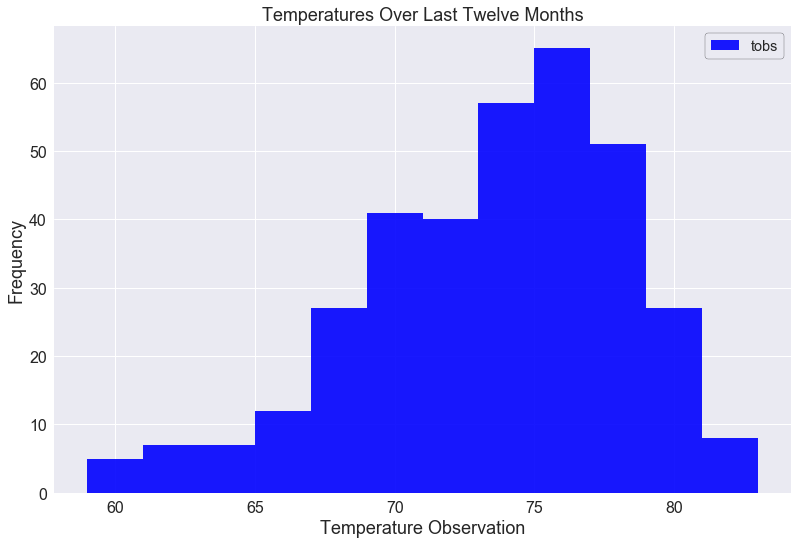

In [84]:
sns.set()
#Plot the results as a histogram with bins=12
x = plot_qry_to_pd['tobs']
num_bins = 12
# the histogram of the data
#n, bins, patches = 
plt.figure(figsize=[12.8, 8])
temp_plot = plt.hist(x, num_bins, facecolor='blue', label='tobs', alpha=0.9)

plt.xlabel('Temperature Observation', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Temperatures Over Last Twelve Months', fontsize=18)
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(axis='x', labelsize=16)
legend = plt.legend(frameon=True, edgecolor='black', fontsize='large')
plt.savefig('images/station_temp_analysis')
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [85]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    temp_stats = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
                 filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    return temp_stats
temp_stats_list = calc_temps('2016-08-28','2017-08-23')
print(temp_stats_list)


[(58.0, 74.53163404642694, 87.0)]


In [86]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Temp=[]
start_date='2016-08-28'
end_date='2017-08-23'
def calc_temps(start_date, end_date):
    results=session.query(func.min(Measurement.tobs).label("min_tobs"), \
                          func.avg(Measurement.tobs).label("avg_tobs"),\
                          func.max(Measurement.tobs).label("max_tobs")).\
                          filter(Measurement.date.between(start_date , end_date))  
    res = results.one()
    res
    TMAX = res.max_tobs
    TMIN= res.min_tobs
    TAVG= res.avg_tobs
    Temp.append(TMAX)
    Temp.append(TMIN)
    Temp.append(TAVG)
    #print(str(TMAX))
    #print(str(TMIN))
    #print(str(TAVG))
calc_temps(start_date, end_date)
Temp

[87.0, 58.0, 74.53163404642694]

In [60]:
TAVG=Temp[2]
TMIN=Temp[1]
TMAX=Temp[0]

C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


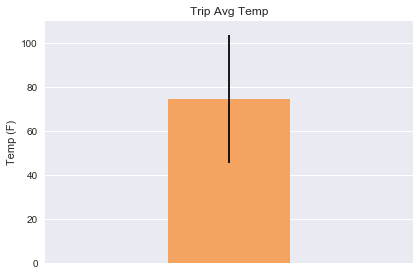

In [61]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar( 1,TAVG, color = 'sandybrown', yerr = TMAX-TMIN, align='center')
plt.xlim(-0.2, 2.2)
plt.ylim([0, 110])
plt.axes().get_xaxis().set_visible(False)
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig('images/Trip_Average_Temp')
plt.show()

In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def collect_rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Measurement.prcp.label('rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by('rainfall DESC').all()

collect_rainfall('2016-08-18', '2017-08-23')

C:\Anaconda\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'rainfall DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00516128', 0.45, 21.3331, -157.8025, 152.4),
 ('USC00517948', 0.16064353974479206, 21.3934, -157.9751, 11.9),
 ('USC00519523', 0.08, 21.33556, -157.71139, 19.5),
 ('USC00519281', 0.06, 21.45167, -157.84888999999995, 32.9),
 ('USC00513117', 0.0, 21.4234, -157.8015, 14.6),
 ('USC00514830', 0.0, 21.5213, -157.8374, 7.0),
 ('USC00519397', 0.0, 21.2716, -157.8168, 3.0)]

## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

def daily_normals(inputdate):
    daily_normals_query = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
                          filter(Measurement.date == func.strftime("%Y-%m-%d",inputdate)).all()
    return daily_normals_query

daily_normals('2017-08-23')

[(76.0, 80.25, 82.0)]

In [31]:
date_list = ['2017-01-01','2017-01-02','2017-01-03','2017-01-04','2017-01-05']
daily_normals_list = []
for date in date_list:
    temp_stat = daily_normals(date)
    daily_normals_list.append(temp_stat)
daily_normals_list

[[(62.0, 69.33333333333333, 74.0)],
 [(66.0, 69.2, 74.0)],
 [(63.0, 67.66666666666667, 73.0)],
 [(62.0, 67.16666666666667, 73.0)],
 [(63.0, 67.5, 72.0)]]

In [32]:
tMin_list = []
tMax_list = []
tAvg_list = []
for row in daily_normals_list:
    tMin_list.append(row[0][0])
    tAvg_list.append(row[0][1])
    tMax_list.append(row[0][2])
tMin_list
tAvg_list
tMax_list
    

[74.0, 74.0, 73.0, 73.0, 72.0]

In [33]:
Daily_normals_df = pd.DataFrame({"Date":date_list,
                  "TMin":tMin_list,
                  "TMax":tMax_list,
                  "TAvg":tAvg_list})
Daily_normals_df.set_index('Date', inplace=True, )
Daily_normals_df.head()

,TMin,TMax,TAvg
Date,,,
2017-01-01,62.0,74.0,69.333333
2017-01-02,66.0,74.0,69.200000
2017-01-03,63.0,73.0,67.666667
2017-01-04,62.0,73.0,67.166667
2017-01-05,63.0,72.0,67.500000


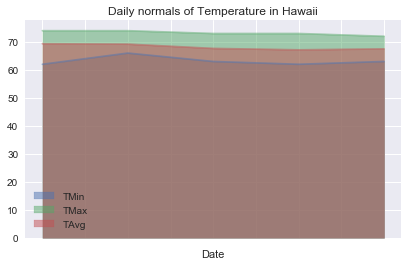

In [34]:
# Plot the daily normals as an area plot with `stacked=False`

Daily_normals_df.plot.area(stacked=False, title='Daily normals of Temperature in Hawaii')
ax = plt.gca()
ax.set_xlabel('Date')
plt.savefig('images/DailyNormal_Temp_hawaii')
plt.show()